<a href="https://colab.research.google.com/github/hanatar/machine/blob/main/week7_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None

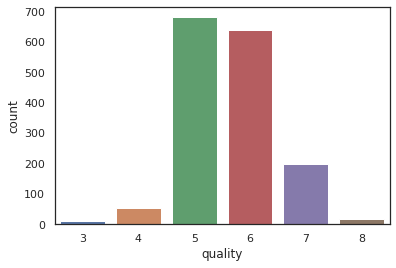

In [8]:
#import data into pandas dataframe
data = pd.read_csv("../content/drive/My Drive/dataset/winequality-red.csv")

#display first 5 lines
data.head()

#print data properties
print('Data Shape: {}'.format(data.shape))

display(data.describe())
display(data.info())
sns.countplot(data['quality'],label="Count")

[Text(0.5, 0, 'fixed acidity'),
 Text(1.5, 0, 'volatile acidity'),
 Text(2.5, 0, 'citric acid'),
 Text(3.5, 0, 'residual sugar'),
 Text(4.5, 0, 'chlorides'),
 Text(5.5, 0, 'free sulfur dioxide'),
 Text(6.5, 0, 'total sulfur dioxide'),
 Text(7.5, 0, 'density'),
 Text(8.5, 0, 'pH'),
 Text(9.5, 0, 'sulphates'),
 Text(10.5, 0, 'alcohol'),
 Text(11.5, 0, 'quality')]

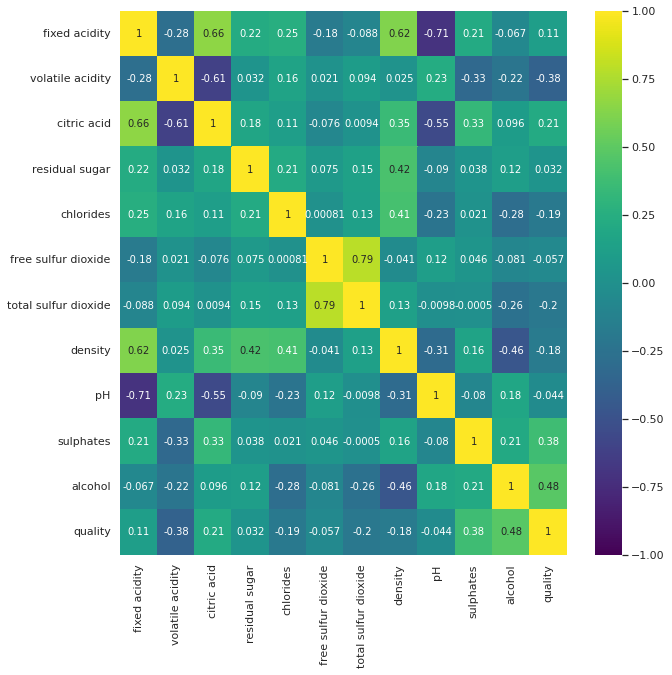

In [9]:
plt.figure(figsize=(10,10))
corr_mat=sns.heatmap(data.corr(method='spearman'),annot=True,cbar=True,
            cmap='viridis', vmax=1,vmin=-1,
            xticklabels=data.columns,yticklabels=data.columns)
corr_mat.set_xticklabels(corr_mat.get_xticklabels(),rotation=90)

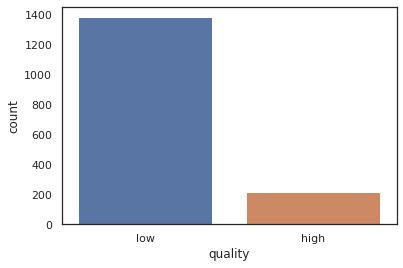

In [10]:
bins = (1, 6.5, 8.5)
quality_level = ['low', 'high']

data['quality'] = pd.cut(data['quality'], bins = bins, labels = quality_level)
sns.countplot(data['quality'])

In [12]:
#Extract data and label target
X = data.iloc[:,0:11]
le = LabelEncoder().fit(data['quality'])
y = le.transform(data['quality'])

X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,stratify=y)

#Scale data
scaler = MinMaxScaler()
scaler.fit(X_train,y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

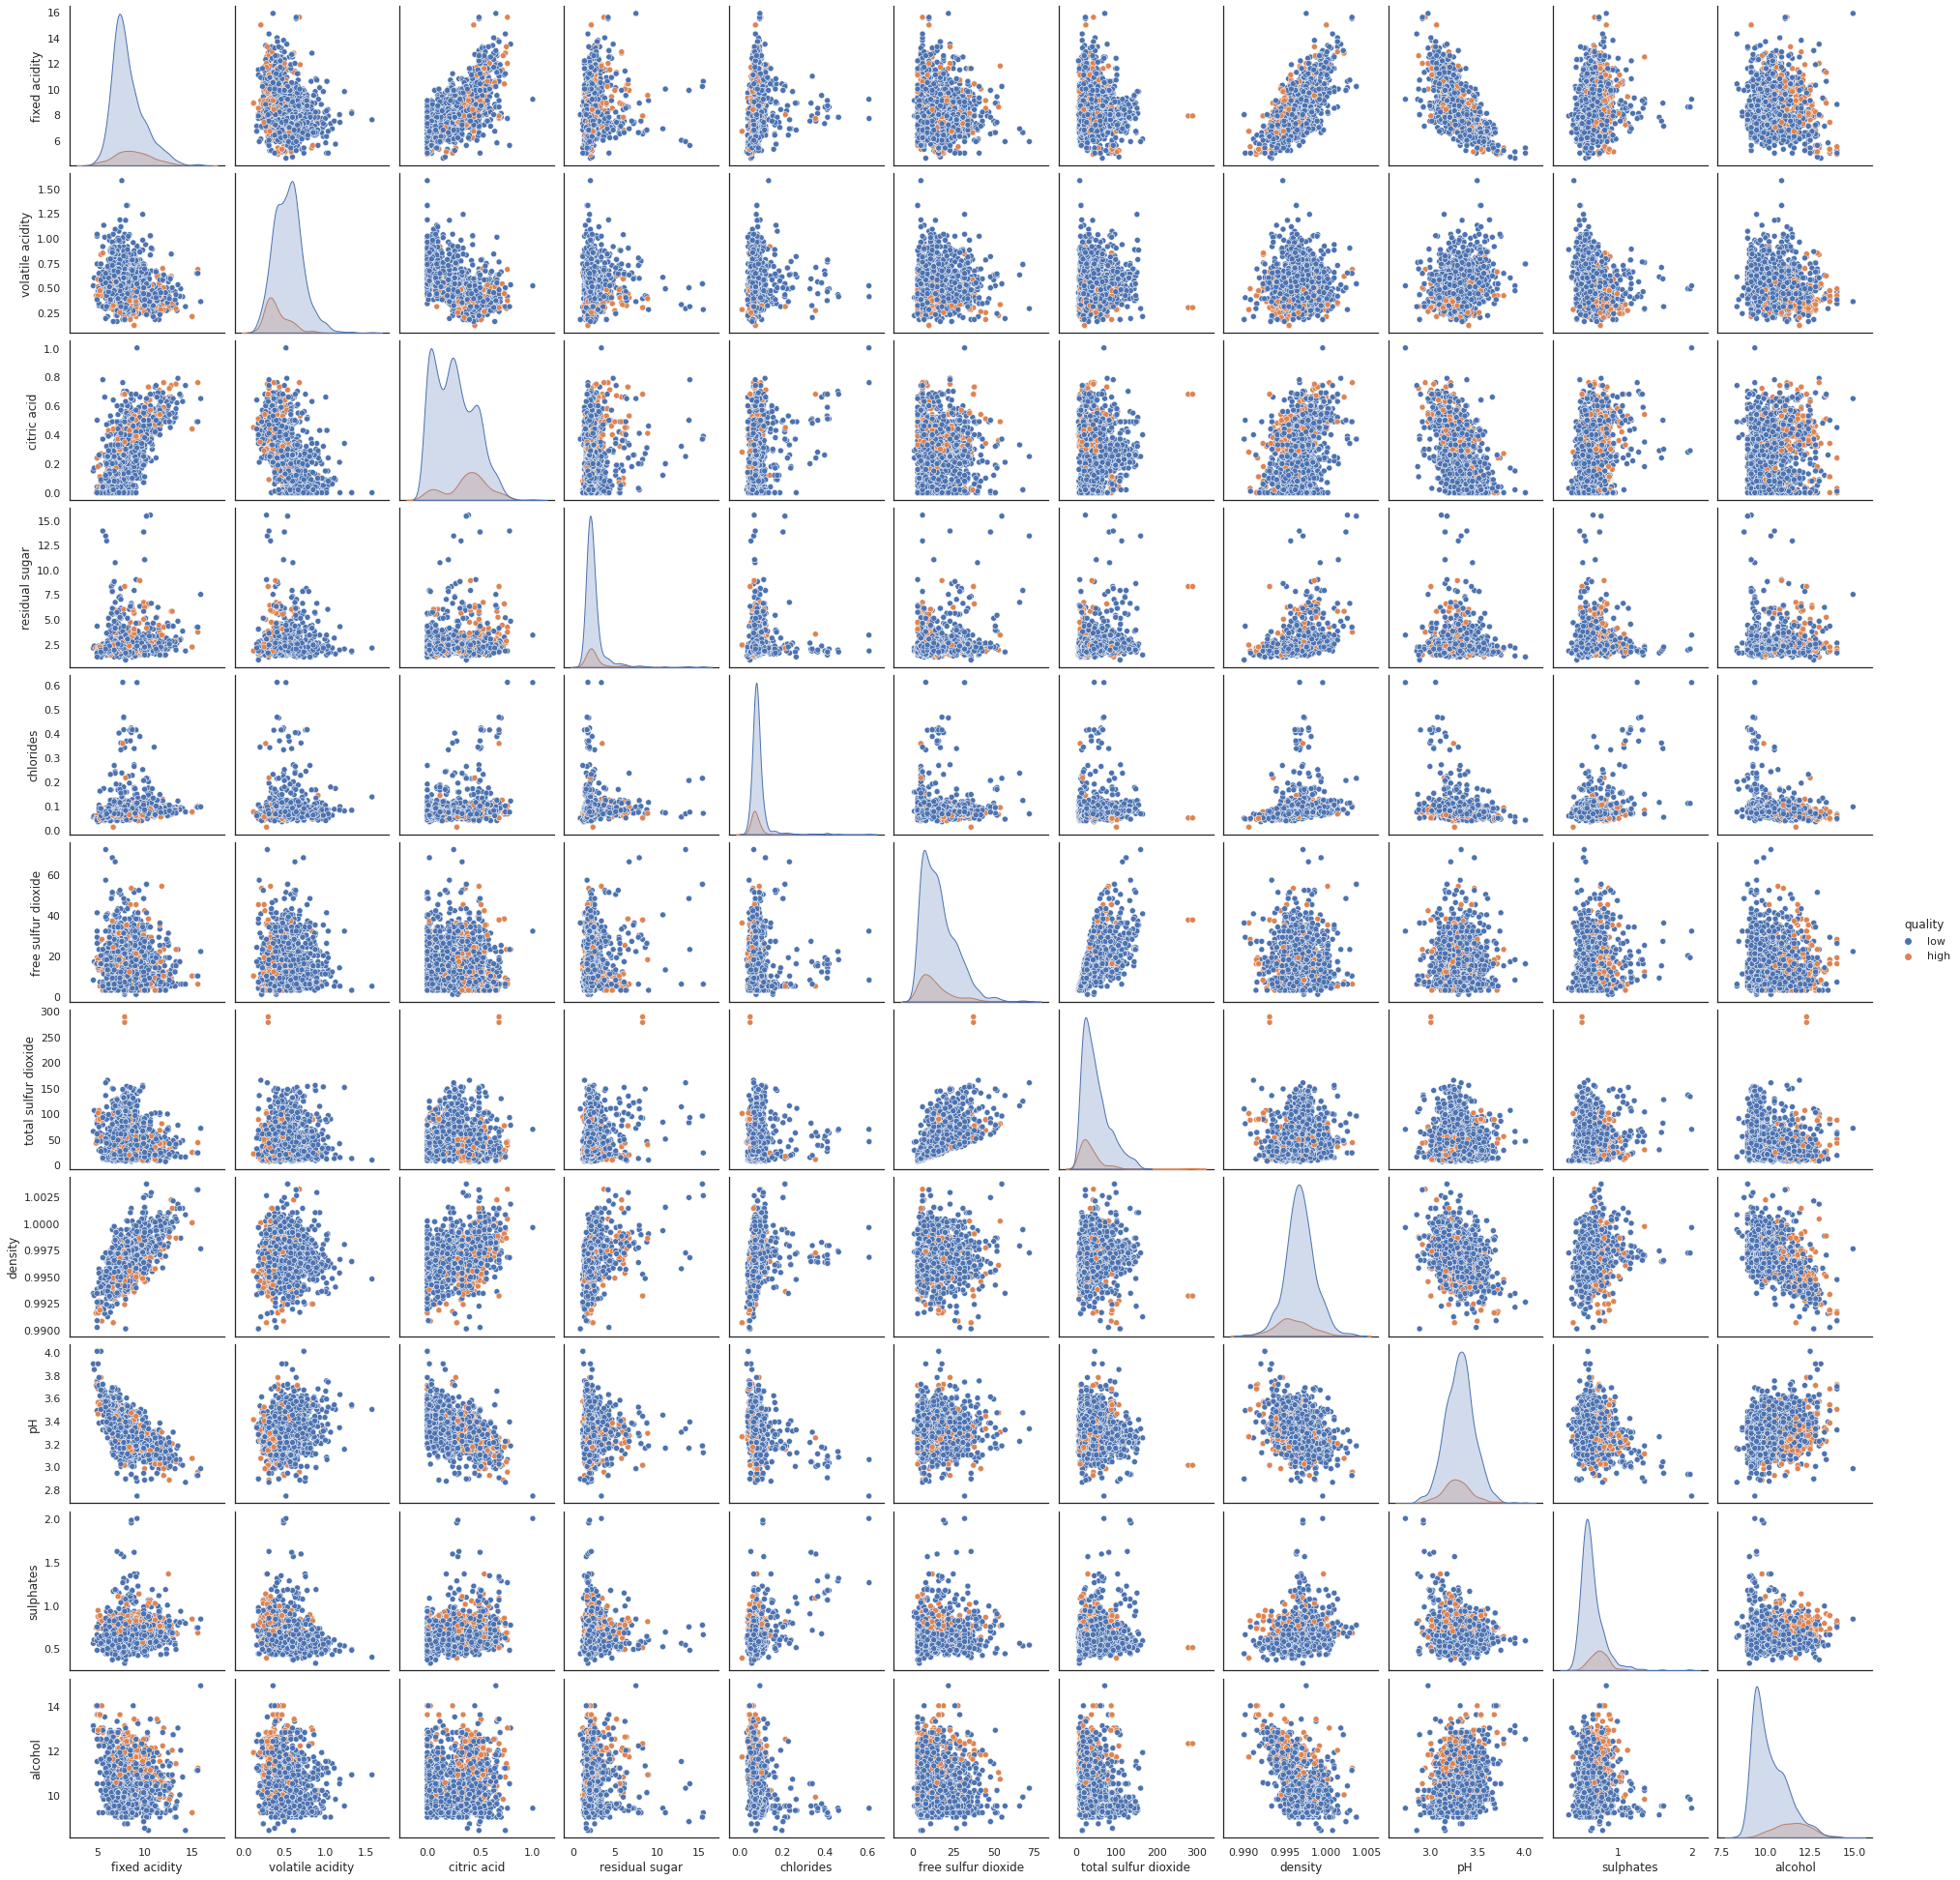

In [13]:
sns.pairplot(data, hue = "quality", diag_kind='kde')

XGBOOST

Best cross-validation accuracy: 0.908
Test set score: 0.925
Best parameters: {'xgb__alpha': 0.001, 'xgb__max_depth': 4, 'xgb__min_samples_leaf': 1, 'xgb__n_estimators': 500}
              precision    recall  f1-score   support

        high       0.76      0.65      0.70        54
         low       0.95      0.97      0.96       346

    accuracy                           0.93       400
   macro avg       0.85      0.81      0.83       400
weighted avg       0.92      0.93      0.92       400



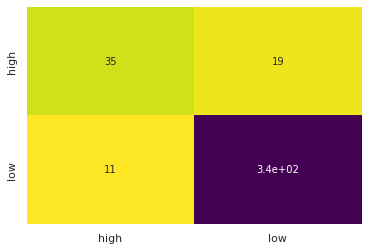

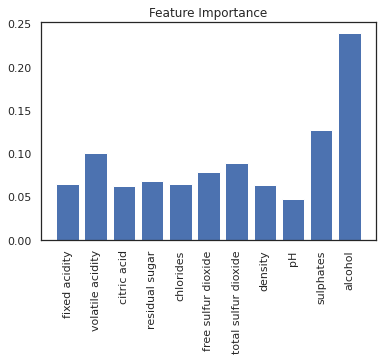

In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
param_grid = {'xgb__n_estimators': [500], 
              'xgb__max_depth': [2,3,4,5], 
              'xgb__alpha': [0.001,0.01,0.1,1],
              'xgb__min_samples_leaf': [1,2,3]}
xgb = XGBClassifier(random_state=0)
pipe = Pipeline([("scaler",MinMaxScaler()), ("xgb",xgb)])
grid_xgb = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.3f}".format(grid_xgb.best_score_))
print("Test set score: {:.3f}".format(grid_xgb.score(X_test,y_test)))
print("Best parameters: {}".format(grid_xgb.best_params_))

conf_mat_xgb = confusion_matrix(y_test, grid_xgb.predict(X_test))
sns.heatmap(conf_mat_xgb, annot=True, cbar=False, cmap="viridis_r",
            yticklabels=le.classes_, xticklabels=le.classes_)

# Feature importance
xgb = XGBClassifier(random_state=0, max_depth=grid_xgb.best_params_['xgb__max_depth'],
                                 n_estimators=grid_xgb.best_params_['xgb__n_estimators'],
                                 alpha=grid_xgb.best_params_['xgb__alpha'],
                                 min_samples_leaf = grid_xgb.best_params_['xgb__min_samples_leaf'])
xgb.fit(X_train_scaled,y_train)
plt.figure()
plt.bar(np.arange(X.shape[1]), xgb.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns, rotation=90)
plt.title('Feature Importance')

# Classification Report
print(classification_report(y_test, xgb.predict(X_test_scaled), target_names=le.classes_))